In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops
from autocorrelationDataProcessing import tracePackageAutocorrelation

In [3]:
# define all needed parameters for simulation and fitting #
from loopFunction import DespondsMs2Loops

stepsize = 3            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0137
k_off = 0.0139
duration = 615   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = SnailPromoterMs2Loops().loop_function

In [4]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [4]:
# Now let's read in Carola's data
table = Table.read('carola-data/carola-control-trace-1.csv')

In [5]:
len(table)

554

In [6]:
datatracelist = []
for name in table.colnames:
    datatracelist.append(table[name])

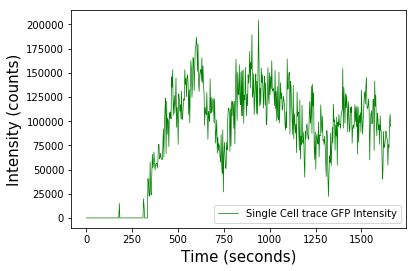

In [66]:
plt.plot(np.arange(len(datatracelist[20]))*stepsize, datatracelist[20], 'g', linewidth=0.7, label = 'Single Cell trace GFP Intensity')
plt.xlabel('Time (seconds)', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.legend(loc='best')

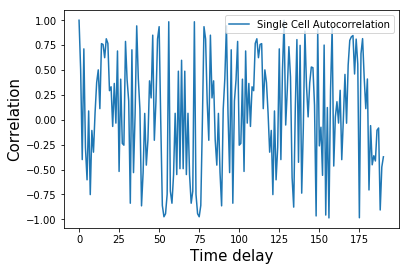

In [67]:
examp = np.correlate(datatracelist[14][300:], datatracelist[14][300:], 'same')
plt.plot(examp[np.argmax(examp):]/np.max(examp), label= 'Single Cell Autocorrelation')
plt.ylabel('Correlation', fontsize=15)
plt.xlabel('Time delay', fontsize=15)
plt.legend(loc='best')
plt.show()

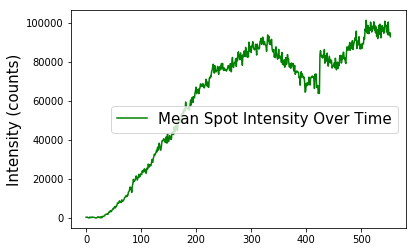

In [68]:
plt.plot(np.mean(datatracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [69]:
# define start and stop indeces
start_index = 180
stop_index = -1

In [70]:
autopackage = tracePackageAutocorrelation(datatracelist, loop_function, start_index, stop_index)

In [71]:
t = np.arange(len(autopackage.tracelist[1][1:])) * stepsize

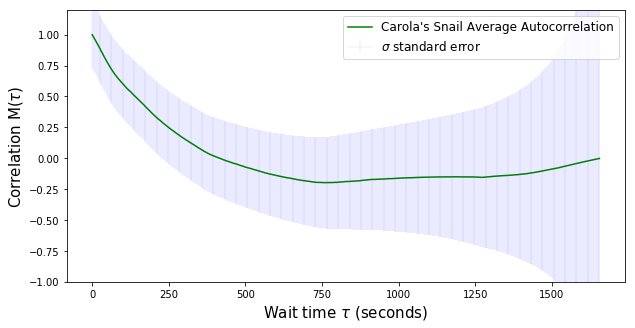

553


In [73]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.autostd
avgflors = autopackage.avgflors

ax.plot(t, autoav, color = 'g', label = "Carola's Snail Average Autocorrelation")
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

print(len(autoav))

In [74]:
# fit for pon in a SIMPLE way
def fitPon(autopackage, loop_function):
    avg_flors = autopackage.avgflors
    pon = np.mean(avg_flors / np.sum(loop_function)) 
    pon_std = np.std(avg_flors/ np.sum(loop_function)) 

    return pon,pon_std

In [75]:
150 % 150

0

In [76]:
pon,pon_std = fitPon(autopackage, loop_function)
print(pon)

0.33522910829057984


In [77]:
def loopInterpolate(loop_function, k_elong, tPol):
    sizePol = k_elong * tPol
    loop_fn_interp = []
    counter=0
    for i in range(len(loop_function)):
        if counter / sizePol >= 1:
            loop_fn_interp.append(loop_function[i])
            counter=0
        else:
            counter += 1
    return np.asarray(loop_fn_interp)
        

In [78]:
interploop = loopInterpolate(loop_function, k_elong, tPol)

len(interploop)

37

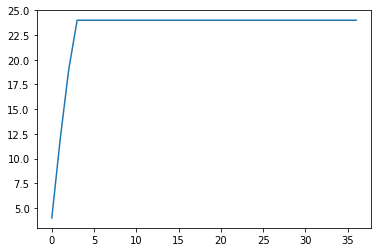

In [79]:
plt.plot(interploop)

In [80]:
def autocorr(t, ratesum):  # take in parameters and t (signal data array index in seconds)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    stepsize = 6            # time between observations, seconds
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
    
    time = np.arange(len(t)) * stepsize
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = interploop
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    #p_on = fitPon(tracelist)
    p_on = 0.33
    p_off = 1-p_on

    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - ratesum    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    
    c_arr = []
    
    for t in range(len(time)):
        sm0 = 0
        for i in range(len(loops)):
            for j in range(len(loops)):
                sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
     
        c_arr.append(sm0)
    #plt.plot(c_arr)
           
    connected_corr = np.asarray(c_arr)    # the two-state connected correlation function
    #return connected_corr / np.max(connected_corr)
   
    N = len(time)         # CONSTANT trace length
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    Co = connected_corr[0]    # initial condition of connected correlation function
        
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(1,N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(1,r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(1,N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
    
        # full correction
        corrected_full.append((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
    
    normed = np.asarray(corrected_full)
    
    return (normed / normed[1])

In [81]:
len(autoav[::50])

12

In [82]:
# get our data's average autocorrelation function
t = np.arange(len(autoav))

In [83]:
np.e

2.718281828459045

In [84]:
%timeit
"""
When fitting the autocorrelation function within the standard deviation error range, we need to exclude the first point
since the standard error here is zero (all autocorr functions normalized there). Otherwise, we get a divide by zero and 
can't fit the fuction
"""
popt,pcov = curve_fit(autocorr, t, autoav, p0=[0.015], 
                           bounds=([0.005],[0.05]))

ratesum = popt[0]

kon_fit = ratesum*pon
koff_fit = ratesum - kon_fit
chrtime = 1 / ratesum

In [85]:
print("k_on + k_off              = ", ratesum, 's^-1')
print("k_on                      = ", kon_fit)
print("k_off                     = ", koff_fit)
print("t_polII_block             =  6 seconds")
print("characteristic timescale  = ", chrtime, 'seconds')
print("covariance                = ", pcov[0][0])

k_on + k_off              =  0.02042542589808333 s^-1
k_on                      =  0.006847197310269791
k_off                     =  0.013578228587813539
t_polII_block             =  6 seconds
characteristic timescale  =  48.95858744829587 seconds
covariance                =  3.467736239519538e-07


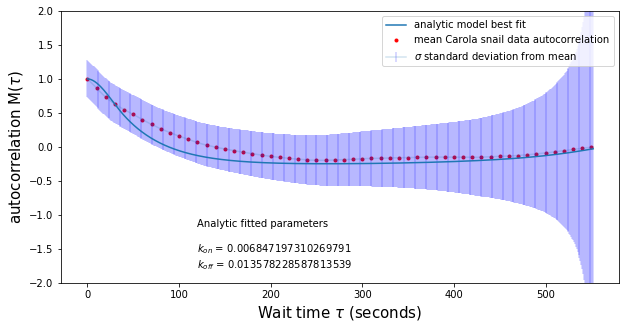

In [86]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, autocorr(t,ratesum=popt[0]), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::10],autoav[::10], marker='.', 
                   color='r', label = 'mean Carola snail data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), 
                        ecolor='b', alpha=0.2, label = r'$\sigma$ standard deviation from mean')  

#plt.plot(chrtime, 1/(np.e), size=20, color='r')
plt.legend(loc="best")
ax.set_ylim(-2, 2)
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'autocorrelation M($\tau$)', fontsize=15)
#plt.text(x=0.07, y=-1.8, 
             #s='Simulated Parameters \n\n$k_{on}$ =' + str(k_on) +
                    # '\n$k_{off}$ = ' + str(k_off) +  '\n$k_{elong}$ = '+ str(k_elong) 
                             #+ ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=120, y=-1.8, s='Analytic fitted parameters \n\n$k_{on}$ = ' 
                                 + str(kon_fit) + '\n$k_{off}$ = ' + str(koff_fit))
plt.show()

In [14]:
# now let's do the analytic model fit to the data
from autocorrelationAnalyticInference import fitAutocorrelationFunction

fitPackage = fitAutocorrelationFunction(autopackage)

In [15]:
fitPackage.leastSquaresAutoFit

<bound method fitAutocorrelationFunction.leastSquaresAutoFit of <autocorrelationAnalyticInference.fitAutocorrelationFunction object at 0x00000053EE371CC0>>

In [16]:
kon_fit,koff_fit,chrtime,cov = fitPackage.leastSquaresAutoFit()

KeyboardInterrupt: 